In [2]:
using Revise
using HydroSolver
using LinearAlgebra
using StaticArrays
using Statistics
using GLMakie,Makie
using IterativeSolvers
using Unitful
using ProfileView
using JLD2

On spécifie le type spatial du mesh: des points 2D.

In [3]:
Point = SVector{2,Float64}

SVector{2, Float64} (alias for SArray{Tuple{2}, Float64, 1, 2})

In [4]:
L_x = inrefunit(2u"mm")
L_y = inrefunit(2u"mm")

L_slot = inrefunit(0.5u"mm")
L_coflow = inrefunit(0.5u"mm")

U_slot = inrefunit(1u"m/s")
T_slot = inrefunit(300u"K")
U_coflow = inrefunit(0.2u"m/s")
T_coflow = inrefunit(300u"K")

ν = inrefunit(15e-6u"m^2/s")
ρ = inrefunit(1.1614u"kg/m^3");

In [5]:
@load "mesh100"
@load "U"
N_x=100
N_y=100
x_range=range(0,stop=L_x,length=N_x)
y_range=range(0,stop=L_y,length=N_y)

N_faces = length(mymesh.faces)
N_cells = length(mymesh.cells);
plot_faces,plot_vertices =  HydroSolver.mesh_to_polygons(mymesh);

In [26]:
species = ["CH4","O2","N2","H2O","CO2","T"]
BC_YT = Dict{String,Vector{HydroSolver.BoundaryConditions{Float64}}}(
    i=>Vector{HydroSolver.BoundaryConditions{Float64}}(undef,length(mymesh.fCenters))
for i in species)

border = [-1 in v for (i,v) in enumerate(mymesh.faces)]
left_border = [-1 in v && mymesh.fCenters[i][1] < mean(x_range[1:2]) for (i,v) in enumerate(mymesh.faces)]
right_border = [-1 in v && mymesh.fCenters[i][1] > mean(x_range[end-1:end]) for (i,v) in enumerate(mymesh.faces)]
bottom_border = [-1 in v && mymesh.fCenters[i][2] < mean(y_range[1:2]) for (i,v) in enumerate(mymesh.faces)]
top_border = [-1 in v && mymesh.fCenters[i][2] > mean(y_range[end-1:end]) for (i,v) in enumerate(mymesh.faces)]

bottom_slot = [0 <= i[1] <= L_slot for i in mymesh.fCenters] .* bottom_border
top_slot = [0 <= i[1] <= L_slot for i in mymesh.fCenters] .* top_border
bottom_coflow = [L_slot < i[1] <= L_slot+L_coflow for i in mymesh.fCenters] .* bottom_border
top_coflow = [L_slot < i[1] <= L_slot+L_coflow for i in mymesh.fCenters] .* top_border


for i in 1:N_faces
    for s in species
        BC_YT[s][i] = HydroSolver.None{Float64}()
    end
    if border[i]
        BC_YT["T"][i] = HydroSolver.Dirichlet{Float64}(300)
    end
    if bottom_slot[i]
        BC_YT["O2"][i] = HydroSolver.Dirichlet{Float64}(0.2)
        BC_YT["N2"][i] = HydroSolver.Dirichlet{Float64}(0.8)
        BC_YT["CH4"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["H2O"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["CO2"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["T"][i] = HydroSolver.Dirichlet{Float64}(300)
    end
    if top_slot[i]
        BC_YT["O2"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["N2"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["CH4"][i] = HydroSolver.Dirichlet{Float64}(1)
        BC_YT["H2O"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["CO2"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["T"][i] = HydroSolver.Dirichlet{Float64}(300)
    end
    if bottom_coflow[i]
        BC_YT["O2"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["N2"][i] = HydroSolver.Dirichlet{Float64}(1)
        BC_YT["CH4"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["H2O"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["CO2"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["T"][i] = HydroSolver.Dirichlet{Float64}(300)
    end
    if top_coflow[i]
        BC_YT["O2"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["N2"][i] = HydroSolver.Dirichlet{Float64}(1)
        BC_YT["CH4"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["H2O"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["CO2"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_YT["T"][i] = HydroSolver.Dirichlet{Float64}(300)
    end
end

In [27]:
DiffusYT = Dict(i=> HydroSolver.diffusion(mymesh,BC_quantity=BC_YT[i]) for i in species);
∇ = HydroSolver.gradient(mymesh)
J = HydroSolver.interpolation(mymesh,method=:Central)
Sum=HydroSolver.face_sum(mymesh);
fV = HydroSolver.face_vecs(mymesh);

In [40]:
YT = Dict(i=>zeros(N_cells) for i in species)
YT["T"] = 300.0*ones(N_cells)
YT["T"][[norm(i[2]-1)<0.25 for i in mymesh.cCenters]] .= 1000
YT["N2"] = 0.8*ones(N_cells)
YT["O2"] = 0.2*ones(N_cells);

In [45]:
ρ = inrefunit(1.1614u"kg/m^3")
c_p = inrefunit(1200u"J/kg/K")
A = inrefunit(1.1e8u"s^-1")
T_A = inrefunit(1e4u"K")
W = inrefunit.([16,32,28,18,44].*1u"g/mol")
νk = [-1,-2,0,2,1]
enthalpy = inrefunit.([-74.9,0,0,-241.818,-393.52].*1u"kJ/mol");

In [47]:
function ωYT(Y,T)
    Q = A*Y[1]*Y[2]^2*exp(-T_A/T)
    ωk = W.*νk.*Q
    ωt = -sum(enthalpy[k]/W[k]*ωk[k] for k in 1:5)
    return ωk/ρ,ωt/(ρ*c_p)
end

function ωYT(YT)
    vcat(ωYT(YT[1:5],YT[6])...)
end

ωYT (generic function with 2 methods)

In [41]:
function dt_concentrations(YT)
    Dict(s=> ν*DiffusY[s]*YT[s] - Diagonal(U)*(∇*YT[s]) for s in species)
end
function operator_YT()
    u = HydroSolver.split(Diagonal(U))
    grad = HydroSolver.split(∇)
    Dict(s=> ν*DiffusYT[s] - sum(u[i]*grad[i] for i in 1:2) for s in species)
end
opYT = operator_YT();

In [42]:
YT_stat = Dict(s=>
    opYT[s].A \ (-opYT[s].B)
for s in species);

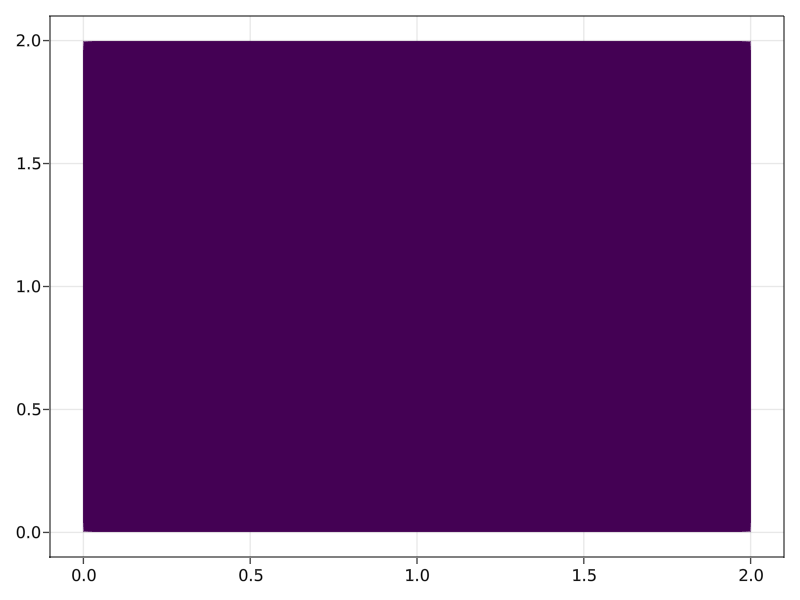

In [50]:
Makie.mesh(plot_vertices,plot_faces, color=HydroSolver.col(YT_stat["CH4"]+YT_stat["N2"]+YT_stat["O2"]),shading=false)

In [36]:
Δt = 1e-6
Δt_c = 1e-8
for i in 1:1000
    for s in species
        Y[s] += 1e-7 * opYT[s]*Y[s] + ωYT
    end

HydroSolver.AffineTransform{SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}(sparse([1, 2, 3, 100, 199, 1, 2, 3, 4, 101  …  9701, 9798, 9799, 9800, 9801, 9603, 9702, 9799, 9800, 9801], [1, 1, 1, 1, 1, 2, 2, 2, 2, 2  …  9800, 9800, 9800, 9800, 9800, 9801, 9801, 9801, 9801, 9801], [-153870.1228544569, 41289.61862740989, 9188.437499999998, 18380.70387961027, 9188.437499999998, -29896.889443938057, -128628.32061680888, 21845.21525308038, 9188.437499999987, 18390.40387233975  …  18171.734197124315, 9188.437499999882, 27.61967543780804, -129050.03673273929, 18366.087657400432, 9188.437499999985, 18307.001418904194, 9188.437499999985, 18392.663113301573, -202275.0582659005], 9801, 9801), [4.410449999999999e7, 2.2052249999999996e7, 2.2052249999999996e7, 2.2052249999999996e7, 2.205225e7, 2.2052249999999996e7, 2.205225e7, 2.2052249999999996e7, 2.205225e7, 2.205225e7  …  2.2052250000000443e7, 2.2052250000000443e7, 2.2052250000000443e7, 2.2052250000000443e7, 2.2052250000000443e7, 2.2